# Robust Journey Planning

Louis Basseto, Frank Schmutz and Kyle Gerard

## Context

In this final project for the EPFL course "Lab In Data Science" we build our own public transport route planner. This route planner is superior to traditional route planners as it allows a user to request the fastest trip with a specific probability of arriving on time. Indeed, given a desired departure, or arrival time, our route planner will compute the fastest route between two stops within a provided uncertainty tolerance. For example, it can retrieve the fastest route from Point A to B with at least P% probability of arriving earlier than time T. It can also find the path departing at time T which is the most likely of arriving the earliest.  

# How

In order to provide this functionality, we use the Open Data Platform Swiss Public Transport’s historical data of Swiss public transport (Buses, Trains, …) collected between 13.09.2017 and 31.01.2019. This dataset contains information for each public transport trip. Here are some of the relevant fields:

* BETRIEBSTAG: date of the trip
* FAHRT_BEZEICHNER: identifies the trip
* BETREIBER_ABK, BETREIBER_NAME: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
* PRODUCT_ID: type of transport, e.g. train, bus
* LINIEN_ID: for trains, this is the train number
* LINIEN_TEXT,VERKEHRSMITTEL_TEXT: for trains, the service type (IC, IR, RE, etc.)
* ZUSATZFAHRT_TF: boolean, true if this is an additional trip (not part of the regular schedule)
* FAELLT_AUS_TF: boolean, true if this trip failed (cancelled or not completed)
* HALTESTELLEN_NAME: name of the stop
* ANKUNFTSZEIT: arrival time at the stop according to schedule
* AN_PROGNOSE: actual arrival time (when AN_PROGNOSE_STATUS is GESCHAETZT)
* AN_PROGNOSE_STATUS: look only at lines when this is GESCHAETZT. This indicates that AN_PROGNOSE is the measured time of arrival.
* ABFAHRTSZEIT: departure time at the stop according to schedule
* AB_PROGNOSE: actual departure time (when AN_PROGNOSE_STATUS is GESCHAETZT)
* AB_PROGNOSE_STATUS: look only at lines when this is GESCHAETZT. This indicates that AB_PROGNOSE is the measured time of arrival.
* DURCHFAHRT_TF: boolean, true if the transport does not stop there
Even though this dataset contains information from the whole of Switzerland, our initial solution  is limited to the Zurich area. We will focus on all the stops within 10km of the Zurich train station (1047 total stations in this area). 


## Our Approach
### Model the public transport infrastructure for your route planning algorithm.
#### Graph
We first transform our dataset into graph form. Stations are represented by vertices. Trips are grouped by departure station, arrival station, day of the week, departure time, arrival time, transport type/line. Each group is then aggregated as one edge which contains the new fields 'lateAvg' and 'lateStd' which is sufficient to compute the probability distribution of a connexion.
Edges contain: 
* 'src': source is the departure station.
* 'dst': Destination is the arrival station.
* 'type': Transport type.
* 'line': Transport line.
* 'departure_day': weekday of departure.
* 'departure_time': departure time of day (precision minute)
* 'arrival_time': arrival time of day (precision minute)
* 'lateAvg': Expected arrival delay
* 'lateStd': Standard deviation of delay

#### Add walking edges
In order for our planner to accommodate connections between different modes of transport, such as from bus to tramways, we add walking edges. An edge is added for every pair of vertices (stations) which are less than 1km away from one another. This edge does not contain a departure day, time or delay statistics. Instead, it only contains a source, destination and walking time. The walking time is a function of inter-station distance, considering a 5km/h walking speed.
After adding these walking connexions, the graph contains a total of 331443 edges and 1047 vertices.
### Predictive model
We assume that a trip’s delay follows a Gaussian distribution. We used the previously computed historical mean delay and standard deviation to compute the probability of making a connexion (probability of previous connection arriving before next connection).
### Implementation of our robust route planning algorithm
In order to achieve both correctness and efficiency we combine two well known algorithms: Dijkstra’s shortest path algorithm and Depth First Search. We use the very fast Dijkstra algorithm as a heuristic to eliminate uninteresting routes which increases the speed of DFS (less explored paths). This allows us to compute any route, regardless of query parameters ( source/destination/probability/time), in under 2.5 seconds. Most queries average 1.5 seconds compute time.
#### Dijkstra’s shortest path algorithm
The Dijkstra shortest path algorithm is first used to compute the shortest path from a destination station from every other station in the Zurich area. This is extremely fast because every station and every edge only has to be visited once. 
#### DFS
DFS is then used to find shortest path meeting the provided uncertainty tolerance. DFS was chosen over BFS because it requires less memory and has a similar compute time. DFS first starts by finding a route that fits the uncertainty tolerance. It then scans through other possible routes. It does not explore paths that do not respect the uncertainty tolerance. It also does not continue exploring routes which depart earlier than our current best route.
Our DFS implementation uses Dijkstra’s shortest path algorithm’s results to determine if a vertex is worth exploring. For example, if Dijkstra outputs that the minimum time required to reach the arrival station from vertex/station S is T. Let T’ be the duration of our current optimal route which meets the uncertainty tolerance and departs at T’ > T. Let T_S be the current DFS path’s time to reach S. Then DFS will not explore trips going through vertex S if T_S + T > T’.
##  Assumptions and shortcomings of the proposed solution
* The planner will not need to mitigate the traveller’s inconvenience if a plan fails.
* The planner assumes that delays or travel times on the public transport network are uncorrelated with one another.
* It does not find contingency plans or take these into account when calculating trip uncertainties.
* Connections of the type “Walk” do not consider earth topography. Indeed, only walking distance as the crow flies is considered when calculating walking time. For example bodies of water or structures which make walking impossible or slower are not taken into account.
* A shortcoming of our solution is that when the transport system changes (new routes, new stops, …) then the probability distributions of trips need to acquire new data and be recalculated. However, It would be relatively simple to update a trip’s expected delay and standard deviation as new historical data becomes available. This would allow the route planner to remain up to date and keep performing optimally. 

## Validation

We use the 15 last weeks of 2017 as our validation data. This means that trips that take place during those weeks are not used to compute estimated trip delay and standard deviation. Instead, they are used to validate the correctness of our stochastic route planner.For this we generate random route queries with different uncertainty tolerance. We use our validation set to see if the route returned by our planner was successful.

We look at different metrics for example:
* compute time as a function of trip length
* Proportion of succesful trips as a function of uncertainty tolerance
* Trip duration as a function of uncertainty tolerance

## Web app and visualizations

We designed a web app which allows the planner to be used. It lets a user input a route query and returns a route. The route is displayed on a map. A heatmap of places that can be reached within a certain duration from a source destination can also be visualized.

# Imports

In [1]:
import datetime as dt
import calendar
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat
import pyspark.sql.functions as functions
import math
import getpass
import pyspark
from datetime import datetime, date, timedelta
from pyspark.sql import SparkSession
import networkx as nx

spark = SparkSession \
    .builder \
    .master("yarn") \
    .appName('journey_planner-{0}'.format(getpass.getuser())) \
    .config('spark.jars.packages', 'graphframes:graphframes:0.6.0-spark2.3-s_2.11') \
    .config('spark.executor.memory', '8g') \
    .config('spark.executor.instances', '5') \
    .config('spark.port.maxRetries', '100') \
    .getOrCreate()

from graphframes import *

# Generate vertices and edges

In [2]:
# load the data
df = spark.read.csv('/datasets/sbb/2018/*/*istdaten.csv.bz2', sep=';', header=True)

In [3]:
stations = pd.read_csv('data/filtered_stations.csv')
valid_stations = set(stations['Remark'])

### Vertices

In [4]:
vertices_df = stations[['Remark', 'Longitude', 'Latitude']]
vertices_df.columns = ['id', 'lon', 'lat']
vertices = spark.createDataFrame(vertices_df)

### Walk edges

In [5]:
stations = stations[['Longitude', 'Latitude', 'Remark']];
stations['key'] = 0

earth_radius = 6371e3

def haversine(row):
    phi1         = 2 * math.pi * float(row['Latitude_x']) / 360
    phi2         = 2 * math.pi * float(row['Latitude_y']) / 360
    delta_phi    = 2 * math.pi * (float(row['Latitude_y']) - float(row['Latitude_x'])) / 360
    delta_lambda = 2 * math.pi * (float(row['Longitude_y']) - float(row['Longitude_x'])) / 360
    
    a = (math.sin(delta_phi/2) ** 2) + \
        math.cos(phi1) * math.cos(phi2) * (math.sin(delta_lambda/2) ** 2)
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    d = earth_radius * c
    
    return d / 1000

prod = pd.merge(stations, stations, on='key')
prod['dist'] = prod.apply(lambda row: haversine(row), axis=1)

In [6]:
# We don't consider walking to stops that are more than 1 kilometers away
max_walking_distance = 1
walk_df = prod[prod['dist'] <= max_walking_distance]
walk_df = walk_df[walk_df['Remark_x'] != walk_df['Remark_y']]

walk_df = walk_df[['Remark_x', 'Remark_y', 'dist']]
walk_df['type'] = 'walk'
walk_df['line'] = 'walk'
walk_df['departure_day']  = 'null'
walk_df['departure_time'] = 'null'
walk_df['arrival_time']   = 'null'
# We assume an average walking speed of 5 kilometers per hour
# We also round the walking time to the upper minute
walk_df['lateAvg'] = walk_df.apply(lambda row: 60 + 60 * ((60 * float(row['dist'])) // 5), axis=1)
walk_df['lateStd'] = 0.0
walk_df.drop('dist', axis=1, inplace=True)
walk_df.columns = ['src', 'dst', 'type', 'line', 'departure_day', 'departure_time', 'arrival_time', 'lateAvg', 'lateStd']

In [7]:
walk_edges = spark.createDataFrame(walk_df)

### Transport edges

In [8]:
dateFormat = 'dd.MM.yyyy HH:mm'
timeLate = (functions.unix_timestamp('AN_PROGNOSE', format=dateFormat)
            - functions.unix_timestamp('ANKUNFTSZEIT', format=dateFormat))

@functions.udf
def clamp(late):
    return 0 if late < 0 else late

arrivals    = df.filter((df.DURCHFAHRT_TF=='false') & 
                        (df.FAELLT_AUS_TF=='false') & 
                        (df.ZUSATZFAHRT_TF=='false') &
                        (df.AN_PROGNOSE_STATUS=='GESCHAETZT') &
                        (df.HALTESTELLEN_NAME.isin(valid_stations))) \
                .select('BETRIEBSTAG',
                        'FAHRT_BEZEICHNER', 
                        'PRODUKT_ID', 
                        'LINIEN_TEXT', 
                        'HALTESTELLEN_NAME', 
                        'AN_PROGNOSE',
                        'ANKUNFTSZEIT') \
                .withColumn('AN_PROGNOSE',  functions.to_timestamp(df.AN_PROGNOSE, dateFormat))  \
                .withColumn('ANKUNFTSZEIT', functions.to_timestamp(df.ANKUNFTSZEIT, dateFormat)) \
                .withColumn('late', clamp(timeLate)) \
                .drop('AN_PROGNOSE')

departures  = df.filter((df.DURCHFAHRT_TF=='false') & 
                        (df.FAELLT_AUS_TF=='false') & 
                        (df.ZUSATZFAHRT_TF=='false') &
                        (df.ABFAHRTSZEIT.isNotNull()) &
                        (df.HALTESTELLEN_NAME.isin(valid_stations))) \
                .select('BETRIEBSTAG',
                        'FAHRT_BEZEICHNER', 
                        'PRODUKT_ID', 
                        'LINIEN_TEXT', 
                        'HALTESTELLEN_NAME', 
                        'ABFAHRTSZEIT') \
                .withColumn('ABFAHRTSZEIT', functions.to_timestamp(df.ABFAHRTSZEIT, dateFormat)) \

In [9]:
arrivals.createOrReplaceTempView('arrivals')
departures.createOrReplaceTempView('departures')

joinQuery = 'SELECT d.HALTESTELLEN_NAME AS src, a.HALTESTELLEN_NAME AS dst,              \
                    d.PRODUKT_ID AS type, d.LINIEN_TEXT AS line,                         \
                    date_format(d.ABFAHRTSZEIT, \'EEEE\') AS departure_day,              \
                    SUBSTRING(d.ABFAHRTSZEIT, 12, 8) AS departure_time,                  \
                    SUBSTRING(a.ANKUNFTSZEIT, 12, 8) AS arrival_time,                    \
                    a.late                                                               \
             FROM arrivals AS a INNER JOIN departures AS d                               \
             ON a.BETRIEBSTAG == d.BETRIEBSTAG                                           \
             AND a.FAHRT_BEZEICHNER == d.FAHRT_BEZEICHNER                                \
             WHERE a.HALTESTELLEN_NAME != d.HALTESTELLEN_NAME                            \
             AND d.ABFAHRTSZEIT < a.ANKUNFTSZEIT'

edges = spark.sql(joinQuery)

In [10]:
edges.createOrReplaceTempView('edges')

query = 'SELECT src, dst, type, line, departure_day, departure_time, arrival_time,              \
         AVG(late) AS lateAvg, STD(late) AS lateStd                                             \
         FROM edges GROUP BY src, dst, type, line, departure_day, departure_time, arrival_time'

aggregated = spark.sql(query)
aggregated_edges = aggregated.na.fill(0.0)

all_edges = aggregated_edges.union(walk_edges)

### Write data to hdfs

In [11]:
#all_edges.write.parquet('/homes/schmutz/edges', mode='overwrite')

In [12]:
#vertices.write.parquet('/homes/schmutz/vertices', mode='overwrite')

# Journey Planner

### Load data from hdfs

In [2]:
vertices = spark.read.parquet('/homes/schmutz/vertices')

edges = spark.read.parquet('/homes/schmutz/edges')

graph = GraphFrame(vertices, edges)

In [3]:
"""
Define some constants
"""
MINUTES_PER_DAY = 1440
MINUTES_PER_HOUR = 60
SECONDS_PER_MINUTE = 60

WALK_SPEED = 1000 * 5 / 60 # meters per minute


def compute_length_in_minutes_between(departure, arrival):
    """
    Computes the interval in minutes between the departure and arrival time
    """
    
    dep = (departure[2:]).split(':')
    arr = (arrival[2:]).split(':')
    day_minutes = (int(arrival[:1]) - int(departure[:1])) * MINUTES_PER_DAY
    hour_minutes = (int(arr[0]) - int(dep[0])) * MINUTES_PER_HOUR
    minutes = (int(arr[1]) - int(dep[1]))
    return day_minutes + hour_minutes + minutes


def compute_prob(arrival, late_avg, late_std, departure):
    """
    Computes the probability that we can use the departure time given that we arrive at the 
    arrival time with a delay represented by a gaussian distribution with mean late_avg and 
    standard deviation late_std
    """
    
    length = compute_length_in_minutes_between(arrival, departure) * SECONDS_PER_MINUTE
    if late_std != 0.0:
        return stat.norm(loc=late_avg, scale=late_std).cdf(length)
    elif late_avg <= length:
        return 1.0
    else:
        return 0.0


def compute_time_between(departure, arrival):
    """
    Computes the interval in hh:mm:ss between the departure and arrival time
    """
    
    dep = (departure[2:]).split(':')
    arr = (arrival[2:]).split(':')
    a = (int(arrival[:1]) - int(departure[:1])) * MINUTES_PER_DAY
    b = (int(arr[0]) - int(dep[0])) * MINUTES_PER_HOUR
    c = (int(arr[1]) - int(dep[1]))
    tot = a + b + c
    hours = tot // MINUTES_PER_HOUR
    minutes = tot % MINUTES_PER_HOUR
    return "{:02d}".format(int(hours)) + ':' + "{:02d}".format(int(minutes)) + ':00'


def time_op(start_time, duration, op='add'):
    """
    Add or subtract the given duration to or from start_time
    """
    
    tmp = start_time.split(':')
    a = int(tmp[0][2:]) * MINUTES_PER_HOUR + int(tmp[1])
    b = duration // SECONDS_PER_MINUTE
    if op == 'add':
        prefix = tmp[0][:2] if a + b < MINUTES_PER_DAY else '1-'
        a = (a + b) % MINUTES_PER_DAY
    elif op == 'sub':
        prefix = tmp[0][:2] if a > b else '0-'
        a = (a - b) % MINUTES_PER_DAY
    minutes = a % MINUTES_PER_HOUR
    hours = (a - minutes) // MINUTES_PER_HOUR
    return prefix + "{:02d}".format(int(hours)) + ':' + "{:02d}".format(int(minutes)) + ':00'


def add_time(start_time, duration):
    """
    Add the given duration to start_time
    """
    return time_op(start_time, duration, 'add')


def sub_time(start_time, duration):
    """
    Subtract the given duration from start_time
    """
    return time_op(start_time, duration, 'sub')


def get_filtered_edges(start_day, finish_day, start_time, finish_time, duration):
    """
    Filters the GraphFrames graph of vertices and edges and returns only the edges that can be used 
    in a valid journey given the constraints
    """
    
    def valid(day, dep_time, arr_time, walk_time):
        if start_day==finish_day:
            return ((day=='null') & (walk_time<=duration)) | \
                    ((day==start_day) & (dep_time>=start_time) & (arr_time<=finish_time) & (dep_time<=arr_time))
        else:
            return ((day=='null') & (walk_time<=duration)) | \
                    (((day==start_day) & (dep_time>=start_time) & ((dep_time<=arr_time) | (arr_time<=finish_time))) | \
                     ((day==finish_day) & (dep_time<finish_time) & (arr_time<=finish_time)))

    return graph.filterEdges(valid(graph.edges.departure_day, 
                                graph.edges.departure_time,
                                graph.edges.arrival_time,
                                graph.edges.lateAvg)).edges


def add_vertex_to_set(max_set, vertex, vertice_costs, subgraph, next_vertices, certain_path, reverse):
    
    max_set.add(vertex)
    cost = vertice_costs[vertex]
    
    if reverse:
        vertice_edges = subgraph.out_edges(vertex, data=True)

        for parallel_paths in vertice_edges:
            edge = parallel_paths[2]
            if edge['type'] == 'walk':
                new_cost = add_time(cost, edge['lateAvg'])
                if (vertex not in next_vertices or next_vertices[vertex]['type'] != 'walk') and \
                    (edge['dst'] not in vertice_costs or new_cost < vertice_costs[edge['dst']]):
                    next_vertices[edge['dst']] = edge
                    vertice_costs[edge['dst']] = new_cost
            elif edge['departure_time'] > cost and \
                (edge['dst'] not in vertice_costs or edge['arrival_time'] < vertice_costs[edge['dst']]):
                if (not certain_path) or vertex not in next_vertices or \
                    compute_prob(cost,  next_vertices[vertex]['lateAvg'], 
                                next_vertices[vertex]['lateStd'], edge['departure_time']) == 1:
                    vertice_costs[edge['dst']] = edge['arrival_time']
                    next_vertices[edge['dst']] = edge
    else:
        vertice_edges = subgraph.in_edges(vertex, data=True)

        for parallel_paths in vertice_edges:
            edge = parallel_paths[2]
            if edge['type'] == 'walk':
                new_cost = sub_time(cost, edge['lateAvg'])
                if (vertex not in next_vertices or next_vertices[vertex]['type'] != 'walk') and \
                    (edge['src'] not in vertice_costs or new_cost > vertice_costs[edge['src']]):
                    next_vertices[edge['src']] = edge
                    vertice_costs[edge['src']] = new_cost
            elif edge['arrival_time'] < cost and \
                (edge['src'] not in vertice_costs or edge['departure_time'] > vertice_costs[edge['src']]):
                if (not certain_path) or compute_prob(edge['arrival_time'],  edge['lateAvg'], edge['lateStd'], cost) == 1:
                    vertice_costs[edge['src']] = edge['departure_time']
                    next_vertices[edge['src']] = edge

                    
def get_max_vertex_not_in_set(max_set, vertice_costs, min_trip_departure_time):
    max_vertex = None
    max_cost = min_trip_departure_time
    for vertex in vertice_costs:
        if vertex not in max_set and vertice_costs[vertex] > max_cost:
            max_cost = vertice_costs[vertex]
            max_vertex = vertex
    
    return max_vertex


def get_min_vertex_not_in_set(max_set, vertice_costs, max_trip_arrival_time):
    max_vertex = None
    max_cost = max_trip_arrival_time
    for vertex in vertice_costs:
        if vertex not in max_set and vertice_costs[vertex] < max_cost:
            max_cost = vertice_costs[vertex]
            max_vertex = vertex
    
    return max_vertex


def find_path(next_vertices, current_vertex, current_path, direction):
    """
    Function only used for testing of find_shortest_path
    find_path(next_vertices, target, [target], direction) returns between the departure and arrival station
    the path is returned in reverse order if direction is set to src
    """
    
    if current_vertex not in next_vertices:
        return current_path
    next_vertex = next_vertices[current_vertex][direction]
    current_path.append(next_vertices[current_vertex])
    return find_path(next_vertices, next_vertex, current_path, direction)
    

def find_shortest_path(subgraph, departure_station, arrival_station, 
                       min_trip_departure_time, max_trip_arrival_time, duration, 
                       get_all_destinations=False, certain_path=False, reverse=False):
    
    """
    Uses Dijkstra's algorithm to find the shortest path between the departure station and the arrival station.
    The functions expects a subgraph of all valid edges in the context of the query.
    
    Returns the latest possible departure time in order to arrive to the destination in time.
    If get_all_destinations is set to True, it instead returns a dictionary mapping station names to latest possible 
    departure times at that station in order to arrive to the destination in time.
    If certain_path is set to True, returns the latest possible departure time in order to arrive to the destination 
    in time and with 100% probability.
    
    If reverse is set to True, then the algorithm is run in reverse order:
    Returns the earliest possible arrival time when leaving on or after the departure time.
    If get_all_destinations is set to True, it instead returns a dictionary mapping station names to earliest possible 
    arrival times at that station if we left on of after the departure time.
    If certain_path is set to True, returns the earliest possible arrival time when leaving on or after the departure 
    time and with 100% probability.
    """
    
    # as day#-hh-mm-ss
    vertice_costs = {}
    max_set = set()
    next_vertices = {}
    if reverse:
        vertice_costs[departure_station] = min_trip_departure_time
        target = arrival_station
        add_vertex_to_set(max_set, departure_station, vertice_costs, subgraph, next_vertices, certain_path, reverse)
        direction = 'src'
    else:
        vertice_costs[arrival_station] = max_trip_arrival_time
        target = departure_station
        add_vertex_to_set(max_set, arrival_station, vertice_costs, subgraph, next_vertices, certain_path, reverse)
        direction= 'dst'

    no_solution = False
    
    while((target not in max_set or get_all_destinations) and not no_solution):
        if reverse:
            min_vertex = get_min_vertex_not_in_set(max_set, vertice_costs, max_trip_arrival_time)
            if min_vertex is None:
                no_solution = True
            else:
                add_vertex_to_set(max_set, min_vertex, vertice_costs, subgraph, next_vertices, certain_path, reverse)
        else:
            max_vertex = get_max_vertex_not_in_set(max_set, vertice_costs, min_trip_departure_time)
            if max_vertex is None:
                no_solution = True
            else:
                add_vertex_to_set(max_set, max_vertex, vertice_costs, subgraph, next_vertices, certain_path, reverse)
    
    if get_all_destinations:
        return vertice_costs
    if no_solution:
        return 'no solution'
    
    if reverse:
        return vertice_costs[arrival_station]
    else:
        return vertice_costs[departure_station]


def compute_expected_arrival_time(arr_time, late_avg, late_std, curr_prob, min_prob_success):
    """
    Computes the upper bound of the arrival time meeting the uncertainty requirement given:
    arr_time the scheduled arrival time
    late_avg the expected delay
    late_std the standard deviation of the delay
    curr_prob the probability of catching the transport that got us here
    min_prob_success the constraint on the uncertainty requirement we have to respect
    """
    
    if late_std != 0:
        remaining_prob = min_prob_success / curr_prob
        expected_late = stat.norm(loc=late_avg, scale=late_std).ppf(remaining_prob)
        if expected_late < 0:
            return arr_time
        elif expected_late == np.inf:
            return None
        else:
            return add_time(arr_time, expected_late)
    else:
        return add_time(arr_time, late_avg)


def compute_paths_heatmap(src, subgraph, visited, 
                          curr_prob, curr_time, curr_lateAvg, curr_lateStd, 
                          min_trip_departure_time, 
                          times, last_line_taken, time_limits, min_prob_success):
    """
    Explore the paths to obtain the heatmap
    src is the current location
    subgraph is the set of valid edges
    visited is a set of already visited stations in the current path
    curr_prob is the current probability of reaching this location
    curr_time is the time at which we arrived at this location according to the schedule
    curr_lateAvg is the delay we expect to add to curr_time to arrive at this location
    curr_lateStd is the standard deviation of the delay
    min_trip_departure time is the time when we began moving from the first station
    times is a dictionary of stations mapping to the earliest arrival time at that station (this function builds this map)
    last_line_taken is the line we took coming from the previous station
    time_limits is a dictionary mapping from stations to the earliest possible arrival time at that station with a probability 
    of 100%
    min_pro_success is the constraint on the uncertainty requirement we have to respect
    """
    
    visited.add(src)
    
    arr_time = compute_expected_arrival_time(curr_time, curr_lateAvg, curr_lateStd, curr_prob, min_prob_success)
    
    if arr_time is not None and (src not in times or times[src] > arr_time):
        times[src] = arr_time
    
    vertice_edges = subgraph.out_edges(src, data=True)
    for vertice_edge in vertice_edges:
        edge = vertice_edge[2]

        if edge['dst'] not in visited and edge['line'] != last_line_taken:

            if edge['type'] == 'walk':
                new_time = add_time(curr_time, edge['lateAvg'])

                if edge['dst'] in time_limits and new_time <= time_limits[edge['dst']]:

                    compute_paths_heatmap(edge['dst'], subgraph, visited, 
                                               curr_prob, new_time, curr_lateAvg, curr_lateStd, 
                                               min_trip_departure_time, times, 
                                               edge['line'], time_limits, min_prob_success)

            elif edge['departure_time'] > curr_time and edge['dst'] in time_limits and \
                 edge['arrival_time'] <= time_limits[edge['dst']]:

                prob = compute_prob(curr_time, curr_lateAvg, curr_lateStd, edge['departure_time'])
                new_prob = curr_prob * prob

                if new_prob >= min_prob_success:
                    compute_paths_heatmap(edge['dst'], subgraph, visited, 
                                               new_prob, edge['arrival_time'], edge['lateAvg'], edge['lateStd'],
                                               min_trip_departure_time, times, 
                                               edge['line'], time_limits, min_prob_success)
        
    visited.remove(src)


def compute_heatmap(subgraph, departure_station, arrival_station,
                    min_trip_departure_time, max_trip_arrival_time, duration,
                    min_probability_of_success):
    """
    Compute a heatmap
    subgraph is the set of valid edges in the context of the query
    departure_station is the station we want to start the heatmap from
    arrival_station is a dummy argument that we do not use
    min_trip_departure_time is the time when we can start moving
    max_trip_arrival_time is the time when we must stop moving
    duration is the difference between the two times
    min_probability of sucess
    """
    
    time_fastest = find_shortest_path(subgraph, departure_station, arrival_station, 
                              min_trip_departure_time, max_trip_arrival_time, duration, 
                              get_all_destinations=True, reverse=True, certain_path=False)

    time_limits = find_shortest_path(subgraph, departure_station, arrival_station, 
                              min_trip_departure_time, max_trip_arrival_time, duration, 
                              get_all_destinations=True, reverse=True, certain_path=True)
    
    for k, v in time_fastest.items():
        if k not in time_limits:
            time_limits[k] = max_trip_arrival_time


    visited = set()
    times = {}
    compute_paths_heatmap(departure_station, subgraph, visited, 1.0, min_trip_departure_time, 0.0, 0.0, 
                          min_trip_departure_time, times, '', time_limits, min_probability_of_success)
    
    heat = {}
    for k, v in times.items():
        if v < max_trip_arrival_time:
            heat[k] = WALK_SPEED * compute_length_in_minutes_between(v, max_trip_arrival_time)

    return heat


def compute_dep_time(max_arr_time, curr_path, edge=None):
    """
    curr_path follows this format: [src, edge, edge, edge, ...] with the edges in normal order
    max_arr_time is only used when computing the departure time of a path with only one (walking) edge 
    if edge is not None then it means we intend to append edge to the end of curr_path
    Returns the departure time
    """
    
    if len(curr_path) == 1:
        dep = max_arr_time if edge is None else edge['departure_time']
    elif curr_path[1]['type'] == 'walk':
        if edge is not None and len(curr_path) == 2:
            dep = sub_time(edge['departure_time'], curr_path[1]['lateAvg'])
        elif len(curr_path) > 2:
            dep = sub_time(curr_path[2]['departure_time'], curr_path[1]['lateAvg'])
        else:
            dep = sub_time(max_arr_time, curr_path[1]['lateAvg'])
    else:
        dep = curr_path[1]['departure_time']
    
    return dep


def compute_arr_time(min_dep_time, curr_path, edge=None):
    """
    curr_path follows this format: [dst, edge, edge, edge, ...] with the edges in reverse order
    min_dep_time is only used when computing the arrival time of a path with only one (walking) edge 
    if edge is not None then it means we intend to append edge to the end of curr_path
    Returns the arrival time
    """
    
    if len(curr_path) == 1:
        arr = min_dep_time if edge is None else edge['arrival_time']
    elif curr_path[1]['type'] == 'walk':
        if edge is not None and len(curr_path) == 2:
            arr = add_time(edge['arrival_time'], curr_path[1]['lateAvg'])
        elif len(curr_path) > 2:
            arr = add_time(curr_path[2]['arrival_time'], curr_path[1]['lateAvg'])
        else:
            arr = add_time(min_dep_time, curr_path[1]['lateAvg'])
    else:
        arr = curr_path[1]['arrival_time']
    
    return arr


def compute_paths_arrival_mode(src, dst, subgraph, visited, curr_path, 
                               curr_prob, curr_time, curr_lateAvg, curr_lateStd, 
                               min_trip_departure_time, max_trip_arrival_time, 
                               paths, last_line_taken, time_limits, min_prob_success, best_times):
    """
    Use the depth first search algorithm on the subgraph to find the potential trips that depart the latest 
    while still meeting the uncertainty requirement
    src is the current location
    dst is the destination
    subgraph is the set of edges valid under the constraints of the query
    visited is the set of already visited stations in the current path
    curr_path is the current path
    curr_prob is the probability that the current path is possible
    curr_time is the time we arrived at the current location
    curr_lateAvg is the expected delay on current_time
    curr_lateStd is the standard deviation of the delay
    min_trip_departure_time is the time when we can start moving from the first station
    max_trip_arrival_time is the time when we must arrive at the destination at the latest
    paths is the list of possible paths meeting the requirements that we build in this function
    last_line_taken is the line we last took to arrive at the current location
    time_limits is a dictionary mapping stations to latest possible departure time to arrive at the destination in time
    min_prob_success is the uncertainty requirement we have to respect
    best_times is a dictionary containing a single entry where we store the latest departure time for which we can find a path
    that we currently know
    """
    
    visited.add(src)
    
    if src == dst:
        final_prob = compute_prob(curr_time, curr_lateAvg, curr_lateStd, max_trip_arrival_time) * curr_prob
        if final_prob >= min_prob_success:
            final_path = curr_path.copy()
            final_path.append(curr_time)
            final_path.append(final_prob)
            
            dep = compute_dep_time(min_trip_departure_time, final_path[:-2], None)
            if dep > best_times['dep']:
                best_times['dep'] = dep
            
            paths.append(final_path)
            
    else:
        vertice_edges = subgraph.out_edges(src, data=True)
        for vertice_edge in vertice_edges:
            edge = vertice_edge[2]
            
            if edge['dst'] not in visited and edge['line'] != last_line_taken:
                
                if edge['type'] == 'walk':
                    new_time = add_time(curr_time, edge['lateAvg'])
                    
                    if new_time <= max_trip_arrival_time and \
                       edge['dst'] in time_limits and new_time <= time_limits[edge['dst']]:

                        curr_path.append(edge)
                        compute_paths_arrival_mode(edge['dst'], dst, subgraph, visited, curr_path, 
                                                   curr_prob, new_time, curr_lateAvg, curr_lateStd, 
                                                   min_trip_departure_time, max_trip_arrival_time, paths, 
                                                   edge['line'], time_limits, min_prob_success, best_times)
                        curr_path.pop();
                        
                elif edge['departure_time'] > curr_time and edge['dst'] in time_limits and \
                     edge['arrival_time'] <= time_limits[edge['dst']]:
                        
                    dep = compute_dep_time(curr_time, curr_path, edge = edge)
                    
                    prob = compute_prob(curr_time, curr_lateAvg, curr_lateStd, edge['departure_time'])
                    new_prob = curr_prob * prob
                    
                    if dep >= best_times['dep'] and new_prob >= min_prob_success:
                        curr_path.append(edge)
                        compute_paths_arrival_mode(edge['dst'], dst, subgraph, visited, curr_path, 
                                                   new_prob, edge['arrival_time'], edge['lateAvg'], edge['lateStd'],
                                                   min_trip_departure_time, max_trip_arrival_time, paths, 
                                                   edge['line'], time_limits, min_prob_success, best_times)
                        curr_path.pop();
        
    visited.remove(src)


def compute_paths_departure_mode(src, dst, subgraph, visited, curr_path, 
                                 curr_prob, curr_time, 
                                 min_trip_departure_time, max_trip_arrival_time, 
                                 paths, last_line_taken, time_limits, min_prob_success, best_times):
    """
    Use the depth first search algorithm on the subgraph to find the potential trips that arrive the earliest 
    while still meeting the uncertainty requirement. In this function we begin our search from the destination to the source.
    src is the source (departure station)
    dst is the current location
    subgraph is the set of edges valid under the constraints of the query
    visited is the set of already visited stations in the current path
    curr_path is the current path
    curr_prob is the probability that the current path is possible
    curr_time is the time we depart from the current location
    min_trip_departure_time is the time when we can start moving from the first station
    max_trip_arrival_time is the time when we must arrive at the destination at the latest
    paths is the list of possible paths meeting the requirements that we build in this function
    last_line_taken is the line we last take to arrive at the next location from the current location
    time_limits is a dictionary mapping stations to earliest possible arrival time in order to depart from the source 
    after the min departure time
    min_prob_success is the uncertainty requirement we have to respect
    best_times is a dictionary containing a single entry where we store the earliest arrival time for which we can find a path
    that we currently know
    """
    
    visited.add(dst)
    
    if src == dst:
        final_path = curr_path.copy()
        final_path.append(curr_time)
        final_path.append(curr_prob)

        arr = compute_arr_time(max_trip_arrival_time, final_path[:-2], None)
        if arr < best_times['arr']:
            best_times['arr'] = arr
        
        paths.append(final_path)
            
    else:
        vertice_edges = subgraph.in_edges(dst, data=True)
        for vertice_edge in vertice_edges:
            edge = vertice_edge[2]
            
            if edge['src'] not in visited and edge['line'] != last_line_taken:
                
                if edge['type'] == 'walk':
                    new_time = sub_time(curr_time, edge['lateAvg'])
                    
                    if new_time >= min_trip_departure_time and \
                       edge['src'] in time_limits and new_time >= time_limits[edge['src']]:

                        curr_path.append(edge)
                        compute_paths_departure_mode(src, edge['src'], subgraph, visited, curr_path, 
                                                     curr_prob, new_time, 
                                                     min_trip_departure_time, max_trip_arrival_time, paths, 
                                                     edge['line'], time_limits, min_prob_success, best_times)
                        curr_path.pop();
                        
                elif edge['arrival_time'] < curr_time and edge['src'] in time_limits and \
                     edge['departure_time'] >= time_limits[edge['src']]:
                    
                    arr = compute_arr_time(curr_time, curr_path, edge = edge)
                    
                    prob = compute_prob(edge['arrival_time'], edge['lateAvg'], edge['lateStd'], curr_time)
                    new_prob = curr_prob * prob
                    
                    if arr <= best_times['arr'] and new_prob >= min_prob_success:
                        curr_path.append(edge)
                        compute_paths_departure_mode(src, edge['src'], subgraph, visited, curr_path, 
                                                     new_prob, edge['departure_time'],
                                                     min_trip_departure_time, max_trip_arrival_time, paths, 
                                                     edge['line'], time_limits, min_prob_success, best_times)
                        curr_path.pop();
        
    visited.remove(dst)


def dfs(subgraph, departure_station, arrival_station, 
        min_trip_departure_time, max_trip_arrival_time, duration, 
        min_probability_of_success, mode):
    """
    Use the depth first search algorithm to find the trip that departs / arrives the latest / earliest while 
    still meeting the uncertainty requirement of the query
    subgraph is the set of edges valid under the query constraints
    departure_station and arrival station are the source and destination
    min_trip_departure_time is the time when we can start moving
    max_trip_arrival_time is the time when we must have arrived at the latest
    duration is the difference of the two times
    min_probability_of_success is the uncertainty requirement we have to respect
    mode is either 'departure' (arrive at the destination at the earliest possible moment)
    or 'arrival' (depart from the source at the latest possible moment)
    """
    
    reverse = mode == 'departure'
    
    # Find the latest departures / earliest arrivals for each reachable station
    time_limits = find_shortest_path(subgraph, departure_station, arrival_station, 
                                     min_trip_departure_time, max_trip_arrival_time, duration, 
                                     get_all_destinations=True, reverse=reverse)
    
    # Find the departure / arrival time of the fastest 100% successful trip
    fastest_certain_path = find_shortest_path(subgraph, departure_station, arrival_station, 
                                              min_trip_departure_time, max_trip_arrival_time, duration, 
                                              get_all_destinations=False, certain_path=True, reverse=reverse)
    
    visited = set()
    curr_time = min_trip_departure_time if mode =='arrival' else max_trip_arrival_time
    curr_path = [departure_station] if mode == 'arrival' else [arrival_station]
    paths = []
    
    if fastest_certain_path != "no solution":
        best_times = {'dep': fastest_certain_path} if mode == 'arrival' else {'arr': fastest_certain_path}
    else:
        best_times = {'dep': min_trip_departure_time} if mode == 'arrival' else {'arr': max_trip_arrival_time}
    
    # Compute the paths
    if mode == 'arrival':
        compute_paths_arrival_mode(departure_station, arrival_station, subgraph, 
                                   visited, curr_path, 1.0, curr_time, 0.0, 0.0, min_trip_departure_time, 
                                   max_trip_arrival_time, paths, '', time_limits, 
                                   min_probability_of_success, best_times)
    else:
        compute_paths_departure_mode(departure_station, arrival_station, subgraph, 
                                     visited, curr_path, 1.0, curr_time, min_trip_departure_time, 
                                     max_trip_arrival_time, paths, '', time_limits, 
                                     min_probability_of_success, best_times)
    
    if not paths:
        return {'departure time' : '', 'arrival_time' : '', 
                'duration' : '', 'probability' : 0.0, 'path': []}
    
    # Compute the departure / arrival time and duration of the possible trips
    if mode == 'arrival':
        dep_times = [compute_dep_time(max_trip_arrival_time, path[:-2], None) for path in paths]
        best_indices = np.where(np.array(dep_times) == max(dep_times))[0]
    else:
        arr_times = [compute_arr_time(min_trip_departure_time, path[:-2], None) for path in paths]
        best_indices = np.where(np.array(arr_times) == min(arr_times))[0]
    
    best_paths = []
    durations = []
    probabilities = []
    
    for idx in best_indices:
        best_path = paths[idx]

        path_edges = best_path[1:-2]
        if mode == 'departure':
            path_edges.reverse()

        corrected_edges = []
        # Compute the departure and arrival time for walk edges and remove unnecessary data
        for idx, e in enumerate(path_edges):
            edge = e.copy()
            
            if edge['type'] == 'walk':
                if idx == 0:
                    if len(path_edges) == 1:
                        if mode == 'arrival':
                            edge['arrival_time'] = max_trip_arrival_time
                            edge['departure_time'] = sub_time(edge['arrival_time'], edge['lateAvg'])
                        else:
                            edge['departure_time'] = min_trip_departure_time
                            edge['arrival_time'] = add_time(edge['departure_time'], edge['lateAvg'])
                    else:
                        edge['arrival_time'] = path_edges[1]['departure_time']
                        edge['departure_time'] = sub_time(edge['arrival_time'], edge['lateAvg'])
                else:
                    edge['departure_time'] = path_edges[idx - 1]['arrival_time']
                    edge['arrival_time'] = add_time(edge['departure_time'], edge['lateAvg'])

                edge.pop('line');

            edge.pop('departure_day');
            edge.pop('lateAvg');
            edge.pop('lateStd');
            corrected_edges.append(edge)
            

        duration_time = compute_time_between(corrected_edges[0]['departure_time'], corrected_edges[-1]['arrival_time'])
        probability = best_path[-1]
        
        best_paths.append(corrected_edges)
        durations.append(duration_time)
        probabilities.append(probability)
    
    # Pick the trips with the lowest duration among the remaining best trips
    best_duration_indices = np.where(np.array(durations) == min(durations))[0]
    
    best_duration_paths = [best_paths[idx] for idx in best_duration_indices]
    best_duration_probs = [probabilities[idx] for idx in best_duration_indices]
    best_duration = durations[best_duration_indices[0]]
    
    # Pick the trip with the highest success probability among the remaining best trips
    best_probability_index = np.argmax(best_duration_probs)
    
    path_edges = best_duration_paths[best_probability_index]
    best_probability = best_duration_probs[best_probability_index]
    
    
    # Remove prefix from the departure / arrival time
    for edge in path_edges:
        edge['departure_time'] = edge['departure_time'][2:]
        edge['arrival_time'] = edge['arrival_time'][2:]
    
    departure_time = path_edges[0]['departure_time']
    arrival_time = path_edges[-1]['arrival_time']
    
    return {'departure_time' : departure_time, 'arrival_time' : arrival_time, 
            'duration' : best_duration, 'probability': best_probability, 'path': path_edges}


def plan(departure_station, arrival_station=None, 
         start_datetime=None, end_datetime=None, 
         min_probability_of_success=0.0, 
         heatmap=False, heatmap_duration=10):
    """
    Parses the query, creates the subgraph of valid edges in the context of the query, and calls the appropriate
    function to compute the result.
    """

    if min_probability_of_success < 0.0:
        min_probability_of_success = 0.0
    elif min_probability_of_success > 1.0:
        min_probability_of_success = 1.0
    
    if heatmap:
        if start_datetime is None:
            return {}
        else:
            if heatmap_duration < 0:
                heatmap_duration = 0
            elif heatmap_duration > 120:
                heatmap_duration = 120
            end_datetime = start_datetime + timedelta(minutes=heatmap_duration)
        
    else:
        if (start_datetime is None and end_datetime is None) or \
           (start_datetime is not None and end_datetime is not None) or \
            arrival_station is None:
            return {'departure time' : '', 'arrival_time' : '', 
                    'duration' : '', 'path': []}

        elif start_datetime is None:
            mode = 'arrival'
            start_datetime = end_datetime - timedelta(hours=2)

        else:
            mode = 'departure'
            end_datetime = start_datetime + timedelta(hours=2)

    start_time  = str(start_datetime.time())
    end_time = str(end_datetime.time())

    start_day  = calendar.day_name[start_datetime.weekday()]
    end_day = calendar.day_name[end_datetime.weekday()]

    min_trip_departure_time = '0-' + start_time

    end_time_prefix = '0-' if (start_day == end_day) else '1-'
    max_trip_arrival_time = end_time_prefix + end_time

    duration = (end_datetime - start_datetime).seconds

    # Filter out the edges that can't be used for the query
    filtered_edges = get_filtered_edges(start_day, end_day, start_time, end_time, duration).toPandas()

    def to_dt(time):
        """
        Convert the time to a useful format for the implementation of the algorithm
        """

        if time == 'null':
            return 'null'
        elif time >= start_time:
            return '0-' + time
        else:
            return '1-' + time


    filtered_edges['departure_time'] = filtered_edges['departure_time'].map(lambda x: to_dt(x))
    filtered_edges['arrival_time']   = filtered_edges['arrival_time'].map(lambda x: to_dt(x))

    # Create a networkx graph of all the valid edges
    subgraph = nx.from_pandas_edgelist(filtered_edges, 'src', 'dst', edge_attr=True, create_using=nx.MultiDiGraph())

    if heatmap:
        return compute_heatmap(subgraph, departure_station, departure_station,
                               min_trip_departure_time, max_trip_arrival_time, duration,
                               min_probability_of_success)
    
    else:
        return dfs(subgraph, departure_station, arrival_station, min_trip_departure_time, 
                   max_trip_arrival_time, duration, min_probability_of_success, mode)

### Maximizing departure time example

In [127]:
fromStation = 'Kilchberg'
toStation   = 'Urdorf, Schlierenstrasse'
endDateTime   = datetime(2019, 6, 4, 19, 57)

res = plan(fromStation, toStation, 
           end_datetime=endDateTime,
           min_probability_of_success=0.95)

res

{'departure_time': '19:09:00',
 'arrival_time': '19:51:00',
 'duration': '00:42:00',
 'probability': 0.9997405493724597,
 'path': [{'src': 'Kilchberg',
   'dst': 'Zürich HB',
   'type': 'Zug',
   'line': 'S8',
   'departure_time': '19:09:00',
   'arrival_time': '19:23:00'},
  {'src': 'Zürich HB',
   'dst': 'Glanzenberg',
   'type': 'Zug',
   'line': 'S3',
   'departure_time': '19:29:00',
   'arrival_time': '19:40:00'},
  {'src': 'Glanzenberg',
   'dst': 'Urdorf, Schlierenstrasse',
   'type': 'walk',
   'departure_time': '19:40:00',
   'arrival_time': '19:51:00'}]}

### Minimizing arrival time example

In [128]:
fromStation = 'Kilchberg'
toStation   = 'Urdorf, Schlierenstrasse'
startDateTime = datetime(2017, 9, 13, 12, 20)

res = plan(fromStation, toStation, 
           start_datetime=startDateTime,
           min_probability_of_success=0.95)

res

{'departure_time': '12:26:00',
 'arrival_time': '13:06:00',
 'duration': '00:40:00',
 'probability': 0.9999999999662851,
 'path': [{'src': 'Kilchberg',
   'dst': 'Zürich HB',
   'type': 'Zug',
   'line': 'S24',
   'departure_time': '12:26:00',
   'arrival_time': '12:39:00'},
  {'src': 'Zürich HB',
   'dst': 'Glanzenberg',
   'type': 'Zug',
   'line': 'S12',
   'departure_time': '12:44:00',
   'arrival_time': '12:55:00'},
  {'src': 'Glanzenberg',
   'dst': 'Urdorf, Schlierenstrasse',
   'type': 'walk',
   'departure_time': '12:55:00',
   'arrival_time': '13:06:00'}]}

### How far can we go in M minutes example

In [6]:
fromStation = 'Kilchberg'
startDateTime = datetime(2019, 6, 4, 15, 20)

res = plan(fromStation, 
           start_datetime=startDateTime,
           min_probability_of_success=0.95, heatmap=True, heatmap_duration=30)
res

{'Kilchberg': 2500.0,
 'Zürich HB': 916.6666666666666,
 'Zürich Hardbrücke': 333.3333333333333,
 'Zürich Hardbrücke, Bahnhof': 250.0,
 'Zürich Stadelhofen': 666.6666666666666,
 'Zürich Tiefenbrunnen': 83.33333333333333,
 'Zürich Stadelhofen FB': 583.3333333333333,
 'Zürich Kreuzplatz': 166.66666666666666,
 'Zürich, Bellevue': 333.3333333333333,
 'Zürich, Opernhaus': 500.0,
 'Zürich, Kreuzstrasse': 250.0,
 'Zürich, Helmhaus': 83.33333333333333,
 'Zürich, Hottingerplatz': 83.33333333333333,
 'Zürich, Kunsthaus': 166.66666666666666,
 'Zürich, Sprecherstrasse': 333.3333333333333,
 'Zürich Oerlikon': 166.66666666666666,
 'Zürich Oerlikon, Bahnhof': 83.33333333333333,
 'Zürich Altstetten': 416.66666666666663,
 'Zürich Altstetten, Bahnhof': 333.3333333333333,
 'Zürich Altstetten, Bahnhof N': 250.0,
 'Zürich, Baslerstrasse': 83.33333333333333,
 'Zürich, Bristenstrasse': 166.66666666666666,
 'Zürich, Würzgraben': 83.33333333333333,
 'Zürich HB SZU': 750.0,
 'Zürich Landesmuseum (See)': 750.0,
 

# Validation

### Create validation data

In [11]:
# load the data
df = spark.read.csv('/datasets/sbb/2017/*/*istdaten.csv.bz2', sep=';', header=True)
stations = pd.read_csv('data/filtered_stations.csv')
valid_stations = set(stations['Remark'])

In [12]:
dateFormat = 'dd.MM.yyyy HH:mm'

arrivals = df.filter((df.DURCHFAHRT_TF=='false') & 
                     (df.FAELLT_AUS_TF=='false') & 
                     (df.ZUSATZFAHRT_TF=='false') &
                     (df.AN_PROGNOSE_STATUS=='GESCHAETZT') &
                     (df.HALTESTELLEN_NAME.isin(valid_stations))) \
             .select('LINIEN_TEXT', 
                     'HALTESTELLEN_NAME', 
                     'ANKUNFTSZEIT', 
                     'AN_PROGNOSE') \
             .withColumn('AN_PROGNOSE',  functions.to_timestamp(df.AN_PROGNOSE, dateFormat))  \
             .withColumn('ANKUNFTSZEIT',  functions.to_timestamp(df.ANKUNFTSZEIT, dateFormat))

In [13]:
#arrivals.write.parquet('/homes/schmutz/validation_stops', mode='overwrite')

### Load validation data

In [4]:
val_stops = spark.read.parquet('/homes/schmutz/validation_stops')
stations = pd.read_csv('data/filtered_stations.csv')
valid_stations = list(stations['Remark'])

In [73]:
NUM_VALIDATION_WEEKS = 15

DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

DATE = {'Monday'    : date(2017, 9, 18),
        'Tuesday'   : date(2017, 9, 19),
        'Wednesday' : date(2017, 9, 13),
        'Thursday'  : date(2017, 9, 14),
        'Friday'    : date(2017, 9, 15),
        'Saturday'  : date(2017, 9, 16),
        'Sunday'    : date(2017, 9, 17)}


def get_stops(stations_set, lines_set, arrivals_set):
    """
    Filter the stops to keep only relevant stops that are part of the trip
    stations_set is the set of arrival stations in the trip
    lines_set is the set of lines taken during the trip
    arrivals_set is the set of arrival times of transports in the trip
    Return the resulting stops as a pandas dataframe
    """
    
    arrivals = val_stops.filter((val_stops.LINIEN_TEXT.isin(lines_set)) &
                                (val_stops.ANKUNFTSZEIT.isin(arrivals_set)) &
                                (val_stops.HALTESTELLEN_NAME.isin(stations_set))) \
                        .drop(val_stops.ANKUNFTSZEIT)
    
    
    arr_df = arrivals.toPandas()
    arr_df.columns = ['line', 'station', 'arrival_time']
    
    return arr_df


def to_timeobj(timestr):
    """
    Convert the time string to a time object
    """
    
    t = timestr.split(':')
    return dt.time(int(t[0]), int(t[1]), int(t[2]))


def is_trip_valid(trip, end_time=None):
    """
    Check if the given path is valid, i.e., if all arrival times happen before the 
    next departure time / max arrival time
    """
    
    for idx, edge in enumerate(trip):
        if idx > 0:
            if trip[idx - 1]['arrival_time'] > edge['departure_time'] or \
               (end_time != None and edge['arrival_time'] > end_time):
                return False
    return True


def check_query(query_res, trip_dt, mode):
    """
    Correct the trip given by the planner with the actual arrival times of that trip
    Then check if this schedule would have been possible
    """
    
    trip_dt_str = str(trip_dt.date())
    
    s_set = set()
    l_set = set()
    a_set = set()

    for edge in query_res['path']:
        if edge['type'] != 'walk':
            s_set.add(edge['dst'])
            l_set.add(edge['line'])
            a_set.add(trip_dt_str + ' ' + edge['arrival_time'])

    arrivals = get_stops(s_set, l_set, a_set)

    new_path = []

    for e in query_res['path']:
        edge = e.copy()
        if edge['type'] != 'walk':
            entry = arrivals[(arrivals['line'] == edge['line']) & (arrivals['station'] == edge['dst'])]
            
            if len(entry.values) == 0:
                # trip didn't happend at all that day
                return 'pass'
            
            timestr = str(entry.values[0][2])[11:]
            edge['arrival_time'] = to_timeobj(timestr)
            edge['departure_time'] = to_timeobj(edge['departure_time'])
        else:
            edge['departure_time'] = to_timeobj(edge['departure_time'])
            edge['arrival_time'] = to_timeobj(edge['arrival_time'])

        new_path.append(edge)

    for idx, edge in enumerate(new_path):
        if edge['type'] == 'walk' and idx > 0:
            prev_arr = new_path[idx - 1]['arrival_time']
            if (prev_arr > edge['departure_time']):
                timediff = datetime.combine(date.today(), prev_arr) - datetime.combine(date.today(), edge['departure_time'])
                edge['departure_time'] = prev_arr
                edge['arrival_time'] = (datetime.combine(date.today(), edge['arrival_time']) + timediff).time()
    
    
    if mode == 'arrival':
        return is_trip_valid(new_path, end_time=trip_dt.time())
    else :
        return is_trip_valid(new_path)


def validate_query(departure_station, arrival_station, min_probability_of_success, 
                   start_datetime=None, end_datetime=None):
    """
    Get the planner's schedule for this query, then check if the schedule would have been
    possible in each of the 15 weeks of the validation set and return the total number of 
    trips that happenend (can be less than 15 if some transports were cancelled), the number of these 
    trips that would have succeeded and the predicted probability of success given by the journey 
    planner
    """

    if (start_datetime == None and end_datetime == None) or \
       (start_datetime != None and end_datetime != None):
        return False
    
    elif start_datetime != None:
        mode = 'departure'
        query_res = plan(departure_station, arrival_station, 
                         start_datetime=start_datetime,
                         min_probability_of_success=min_probability_of_success)
        
        trip_dt = start_datetime
    
    else:
        mode = 'arrival'
        query_res = plan(departure_station, arrival_station, 
                         end_datetime=end_datetime,
                         min_probability_of_success=min_probability_of_success)
        
        trip_dt = end_datetime
    
    if not query_res['path']:
        return 0, 0, 0
    
    trip_dts = []
    for i in range(NUM_VALIDATION_WEEKS):
        trip_dts.append(trip_dt + timedelta(weeks=i))
    
    
    nb_valids = 0
    nb_invalids = 0
    for trip_dt in trip_dts:
        query_state = check_query(query_res, trip_dt, mode)
        if query_state == 'pass':
            pass
        elif query_state:
            nb_valids += 1
        else:
            nb_invalids += 1

    return nb_valids + nb_invalids, nb_valids, query_res['probability']


def get_random_query(random_week=False):
    """
    Generate and return a random query from the first week of the validation set
    if random_week is set to True then the week is also randomly generated
    """
    
    day = DATE[DAYS[np.random.randint(0, len(DAYS))]]
    h = np.random.randint(5, 22)
    m = np.random.randint(0, 60)
    
    trip_datetime = datetime.combine(day, dt.time(h, m))
    if random_week:
        trip_datetime = trip_datetime + timedelta(weeks=np.random.randint(0, NUM_VALIDATION_WEEKS))
    
    departure_station = valid_stations[np.random.randint(0, len(valid_stations))]
    
    arrival_station = departure_station
    while arrival_station == departure_station:
        arrival_station = valid_stations[np.random.randint(0, len(valid_stations))]
    
    return departure_station, arrival_station, trip_datetime


def get_random_query_batch(batchsize=100, random_week=False):
    """
    Return batchsize random queries
    """
    
    random_queries = []
    
    for i in range(batchsize):
        random_queries.append(get_random_query(random_week=random_week))
    
    return random_queries


def get_random_query_low_prob(threshold=0.5, random_week=False, mode=None):
    """
    Generate and return a random query for which the journey planner predicts 
    the fastest possible schedule to have a probability of success lower than 
    the threshold
    """
    
    found = False
    
    return_mode = mode is None
    
    while not found:
        dep_station, arr_station, trip_dt = get_random_query(random_week=random_week)
        
        if mode is None:
            mode = np.random.choice(['departure', 'arrival'])
        
        if mode == 'arrival':
            query_res = plan(dep_station, arr_station, end_datetime=trip_dt)
        else:
            query_res = plan(dep_station, arr_station, start_datetime=trip_dt)
    
        if (not query_res['path']) or query_res['probability'] >= threshold:
            continue
        
        found = True
    
    if return_mode:
        return dep_station, arr_station, trip_dt, mode
    else:
        return dep_station, arr_station, trip_dt


def get_random_query_low_prob_batch(batchsize=50, threshold=0.5, random_week=False, mode=None):
    """
    Return batchsize random queries with fastest schedules having a probability of success 
    lower than the threshold
    """
    
    queries = []
    
    for i in range(batchsize):
        queries.append(get_random_query_low_prob(threshold=threshold, random_week=random_week, mode=mode))
        
        print('#', end='')
    
    return queries


def benchmark_average_time_loss(validation_queries, mode, min_prob_success):
    """
    Benchmark the average time that is lost by following a schedule 
    with min_prob_success compared to following the fastest schedule 
    regardless of the probability of failure
    This time is averaged over all the queries in validation_queries
    """
    
    nb_validation_queries = len(validation_queries)
    sum_minutes_lost = 0
    nb_executed_queries = 0
    
    i = 0
    for validation_query in validation_queries:
        src, dst, trip_dt = validation_query

        if mode == 'departure':
            query_res = plan(src, dst, 
                             start_datetime=trip_dt,
                             min_probability_of_success=min_prob_success)

            i += 1
            
            if i % (nb_validation_queries // 50) == 0:
                print('#', end='')
            
            if not query_res['path']:
                continue
            
            naive_res = plan(src, dst, 
                             start_datetime=trip_dt, 
                             min_probability_of_success=0.0)
            
            naive_time = to_timeobj(naive_res['arrival_time'])
            query_time = to_timeobj(query_res['arrival_time'])
            
            timediff = datetime.combine(date.today(), query_time) - datetime.combine(date.today(), naive_time)
            
            sum_minutes_lost += timediff.total_seconds() / 60
            nb_executed_queries += 1
            
        else:
            query_res = plan(src, dst, 
                             end_datetime=trip_dt, 
                             min_probability_of_success=min_prob_success)
            
            i += 1
            
            if i % (nb_validation_queries // 50) == 0:
                print('#', end='')
            
            if not query_res['path']:
                continue
            
            naive_res = plan(src, dst, 
                             end_datetime=trip_dt,
                             min_probability_of_success=0.0)
            
            naive_time = to_timeobj(naive_res['departure_time'])
            query_time = to_timeobj(query_res['departure_time'])
            
            timediff = datetime.combine(date.today(), naive_time) - datetime.combine(date.today(), query_time)
            
            sum_minutes_lost += timediff.total_seconds() / 60
            nb_executed_queries += 1
    
    return sum_minutes_lost / nb_executed_queries


def benchmark_average_exec_time():
    """
    Benchmark the average computing time that the 
    journey planner takes given the duration of the resulting trips.
    We average the time over 10 minutes intervals
    """
    
    min_prob_success = 0.95
    nb_validation_queries = 1000
    
    durations = []
    exec_times = []
    
    i = 0
    while i < nb_validation_queries:
        src, dst, trip_dt = get_random_query()
        
        trip_dt = trip_dt + timedelta(weeks=np.random.randint(0, NUM_VALIDATION_WEEKS))
        mode = np.random.choice(['departure', 'arrival'])
        
        begin_time = time.time()
        if mode == 'arrival':
            query_res = plan(src, dst, 
                             end_datetime=trip_dt,
                             min_probability_of_success=min_prob_success)
        
        else:
            query_res = plan(src, dst, 
                             start_datetime=trip_dt,
                             min_probability_of_success=min_prob_success)
        
        exec_time = time.time() - begin_time
        if not query_res['path']:
            continue
        
        duration = to_timeobj(query_res['duration'])
        duration_minutes = duration.minute + duration.hour * MINUTES_PER_HOUR
        
        durations.append(duration_minutes)
        exec_times.append(exec_time)
        
        i += 1
        
        if i % (nb_validation_queries // 50) == 0:
            print('#', end='')
    
    bins = []
    values = []
    for i in range(5, 120, 10):
        num_tests = 0
        value_sum = 0
        for duration, exec_time in zip(durations, exec_times):
            if (i - 5) <= duration and duration < (i + 5):
                num_tests += 1
                value_sum += exec_time
        if num_tests > 0:
            bins.append(i)
            values.append(value_sum / num_tests)
    
    return bins, values


def validate_random_query(min_prob_success, query):
    """
    Validate the query with min_prob_success
    If the query mode (departure or arrival) is not provided in te query 
    it is randomly generated
    """
    
    if len(query) < 4:
        departure_station, arrival_station, trip_datetime = query
        mode = np.random.choice(['departure', 'arrival'])
    else:
        departure_station, arrival_station, trip_datetime, mode = query
    
    if mode == 'departure':
        return validate_query(departure_station, arrival_station, min_prob_success, start_datetime=trip_datetime)
    else:
        return validate_query(departure_station, arrival_station, min_prob_success, end_datetime=trip_datetime)


def validate_model(min_prob_success, validation_queries):
    """
    Validate all queries in validation_queries with min_prob_success
    Returns the fraction of the queries that met the mininum probability of success,
    the total fraction of successful trips over all queries and the mean probability 
    of success returned by the journey planner over all queries
    """
    
    i = 0
    nb_executed_queries = 0
    
    nb_query_success = 0
    tot_nb_trips = 0
    tot_nb_trips_success = 0
    sum_query_prob = 0
    
    for validation_query in validation_queries:
        nb_trips, nb_trips_success, query_prob = validate_random_query(min_prob_success, validation_query)

        i += 1
        if i % (len(validation_queries) // 50) == 0:
            print('#', end='')
        
        if nb_trips > 0:
            nb_executed_queries += 1
            
            
            if nb_trips_success / nb_trips >= min_prob_success:
                nb_query_success += 1
            
            tot_nb_trips += nb_trips
            tot_nb_trips_success += nb_trips_success
            sum_query_prob += query_prob
    
    fraction_query_success = nb_query_success / nb_executed_queries
    tot_fraction_trip_success = tot_nb_trips_success / tot_nb_trips
    mean_query_prob = sum_query_prob / nb_executed_queries
    
    return fraction_query_success, tot_fraction_trip_success, mean_query_prob

### Uncertainty validation

In [61]:
def plot_validation_probas(mean_queries_prob, fraction_query_success, tot_fraction_trip_success):
    plt.figure(figsize=(18,6))
    y_ticks = [0.0, 0.25, 0.5, 0.75, 1.0]

    plt.subplot(1,3,1)
    plt.xlabel('Probability of success', fontsize=15)
    plt.ylabel('Mean trip probability of success', fontsize=15)
    plt.plot(min_prob_successes, mean_queries_prob);
    plt.xticks(ticks=min_prob_successes);
    plt.yticks(ticks=y_ticks)
    plt.ylim(bottom=0, top=1.05);

    plt.subplot(1,3,2)
    plt.xlabel('Probability of success', fontsize=15)
    plt.ylabel('Fraction of successful queries', fontsize=15)
    plt.plot(min_prob_successes, fraction_query_success);
    plt.xticks(ticks=min_prob_successes);
    plt.yticks(ticks=y_ticks)
    plt.ylim(bottom=0, top=1.05);

    plt.subplot(1,3,3)
    plt.xlabel('Probability of success', fontsize=15)
    plt.ylabel('Fraction of successful trips', fontsize=15)
    plt.plot(min_prob_successes, tot_fraction_trip_success);
    plt.xticks(ticks=min_prob_successes);
    plt.yticks(ticks=y_ticks)
    plt.ylim(bottom=0, top=1.05);

In [62]:
min_prob_successes = [0.0, 0.25, 0.50, 0.75, 0.90]
nb_validation_queries = 500
validation_queries = get_random_query_batch(batchsize=nb_validation_queries)

fraction_query_successes = []
tot_fraction_trip_successes = []
mean_queries_prob = []

for min_prob_success in min_prob_successes:
    print('Validating with min prob {:.2f} '.format(min_prob_success), end=' ')
    fraction_query_success, tot_fraction_trip_success, mean_query_prob = validate_model(min_prob_success, validation_queries)
    print(' done', ' {:.3f}'.format(fraction_query_success), ' {:.3f}'.format(tot_fraction_trip_success), 
          ' {:.3f}'.format(mean_query_prob))
    
    fraction_query_successes.append(fraction_query_success)
    tot_fraction_trip_successes.append(tot_fraction_trip_success)
    mean_queries_prob.append(mean_query_prob)

Validating with min prob 0.00  ################################################## done  1.000  0.957  0.935
Validating with min prob 0.25  ################################################## done  0.984  0.952  0.941
Validating with min prob 0.50  ################################################## done  0.995  0.976  0.964
Validating with min prob 0.75  ################################################## done  0.984  0.976  0.989
Validating with min prob 0.90  ################################################## done  0.957  0.989  0.996


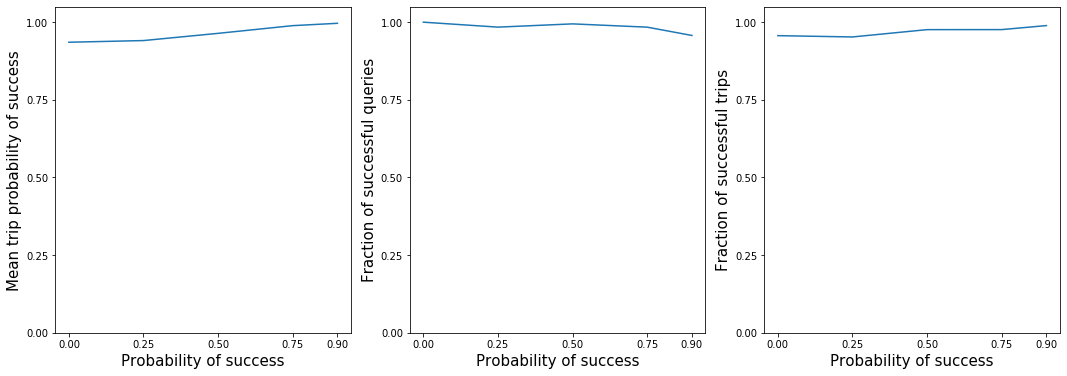

In [66]:
plot_validation_probas(mean_queries_prob, fraction_query_successes, tot_fraction_trip_successes)

#### Results

For this test we used 500 random queries and each query is tested on the 15 weeks of the validation set.

The graph on the left indicates the mean probability of success of the schedules returned by the journey planner. We can see that even when we have no requirement on the probability of success most of the fastest schedules have a high probability of success.

The graph in the middle indicates the fraction of queries for which the returned scheduled met the desired probability of success. To compute it we tested each schedule on the 15 weeks of the validation set and is considered valid if at least the required percentage of those trips were successful. Of course when the desired mininum probability of success is 0 this fraction is always 1 and decreases as the requirement becomes more strict.

The graph on the right indicates the total fraction of successful trips. It makes sense to compare it with the graph on the left as you expect this fraction to increase when the probability of success returned by the journey planner increases.

In [14]:
min_prob_successes = [0.0, 0.25, 0.50, 0.75, 0.90]
nb_validation_queries = 50

print('Generating low prob queries   ', end=' ')
validation_queries = get_random_query_low_prob_batch(batchsize=nb_validation_queries, threshold=0.80)
print(' done')

fraction_query_successes_low_prob = []
tot_fraction_trip_successes_low_prob = []
mean_queries_prob_low_prob = []

for min_prob_success in min_prob_successes:
    print('Validating with min prob {:.2f} '.format(min_prob_success), end=' ')
    fraction_query_success, tot_fraction_trip_success, mean_query_prob = validate_model(min_prob_success, validation_queries)
    print(' done', ' {:.3f}'.format(fraction_query_success), ' {:.3f}'.format(tot_fraction_trip_success), 
          ' {:.3f}'.format(mean_query_prob))
    
    fraction_query_successes_low_prob.append(fraction_query_success)
    tot_fraction_trip_successes_low_prob.append(tot_fraction_trip_success)
    mean_queries_prob_low_prob.append(mean_query_prob)

Generating low prob queries    ################################################## done
Validating with min prob 0.00  ################################################## done  1.000  0.737  0.502
Validating with min prob 0.25  ################################################## done  0.960  0.767  0.578
Validating with min prob 0.50  ################################################## done  1.000  0.898  0.825
Validating with min prob 0.75  ################################################## done  0.979  0.955  0.954
Validating with min prob 0.90  ################################################## done  0.875  0.972  0.994


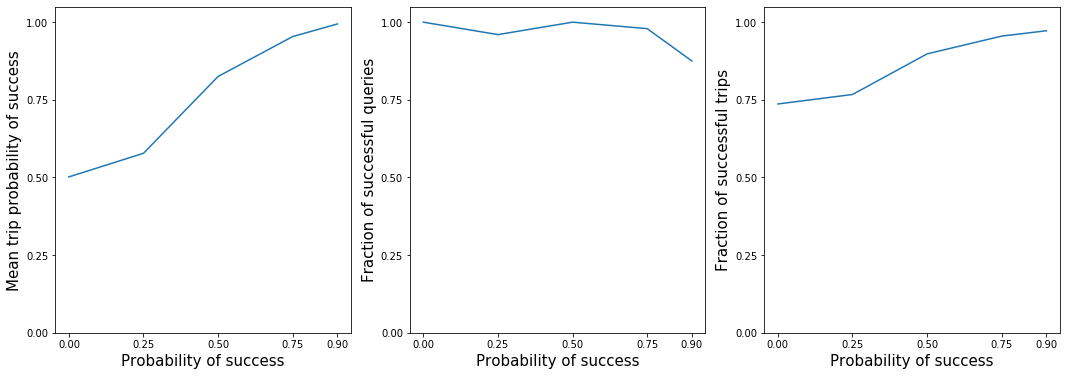

In [50]:
plot_validation_probas(mean_queries_prob_low_prob, fraction_query_successes_low_prob, tot_fraction_trip_successes_low_prob)

#### Results

For this test we used 50 random queries generated such that the fastest possible schedule for each query has a probability of success lower than 80%. We do this because it will give us a better insight into the capabilities of our system when it matters the most. The graphs represent the same quantities as before.

On the left we can see that we choose safer routes as the desired minimum probaility of success increases.

On the right we can also observe a large difference: With no requirement on the minimum probability of success (like the system currently used by the sbb) only 74% of the trips are successful compared to 97% when asking for schedules with a minimum probability of success of 90%.

The differences between the left and the right graphs (schedules are more reliable than predicted by our scheduler for low desired minimum probability of success) can be explained by several factors: 

1) The distribution of delays may not follow a gaussian distribution

2) Very large delays (outliers) can have a significant impact on our model since some combinations of stop / line / time didn't have a lot of data available (Since we classified by day of week we had at most 52 data points for each combination)

### Time loss validation

In [17]:
def plot_validation_time_loss(min_prob_successes, departure_time_loss, arrival_time_loss):
    max_value = max([max(departure_time_loss), max(arrival_time_loss)]) + 0.5
    
    plt.figure(figsize=(18,6))

    plt.subplot(1,2,1)
    plt.xlabel('Probability of success', fontsize=15)
    plt.ylabel('Average departure time lost [minutes]', fontsize=15)
    plt.plot(min_prob_successes, departure_time_loss)
    plt.xticks(ticks=min_prob_successes);
    plt.ylim(bottom=0, top=max_value);

    plt.subplot(1,2,2)
    plt.xlabel('Probability of success', fontsize=15)
    plt.ylabel('Average arrival time lost [minutes]', fontsize=15)
    plt.plot(min_prob_successes, arrival_time_loss)
    plt.xticks(ticks=min_prob_successes);
    plt.ylim(bottom=0, top=max_value);

In [136]:
min_prob_successes = [0.25, 0.50, 0.75, 0.90]

nb_validation_queries = 500
validation_queries = get_random_query_batch(batchsize=nb_validation_queries, random_week=True)

departure_time_loss = []
arrival_time_loss = []

for min_prob_success in min_prob_successes:
    print('Avg dep time lost with min prob {:.2f} '.format(min_prob_success), end=' ')
    avg_deptime_lost = benchmark_average_time_loss(validation_queries, mode='arrival', min_prob_success=min_prob_success)
    print(' done', ' {:.2f}'.format(avg_deptime_lost))
    
    departure_time_loss.append(avg_deptime_lost)
    
for min_prob_success in min_prob_successes:
    print('Avg arr time lost with min prob {:.2f} '.format(min_prob_success), end=' ')
    avg_arrtime_lost = benchmark_average_time_loss(validation_queries, mode='departure', min_prob_success=min_prob_success)
    print(' done', ' {:.1f}'.format(avg_arrtime_lost))
    
    arrival_time_loss.append(avg_arrtime_lost)

Avg dep time lost with min prob 0.25  ################################################## done  0.3
Avg dep time lost with min prob 0.50  ################################################## done  0.9
Avg dep time lost with min prob 0.75  ################################################## done  1.6
Avg dep time lost with min prob 0.90  ################################################## done  2.8
Avg arr time lost with min prob 0.25  ################################################## done  0.2
Avg arr time lost with min prob 0.50  ################################################## done  0.4
Avg arr time lost with min prob 0.75  ################################################## done  0.9
Avg arr time lost with min prob 0.90  ################################################## done  1.1


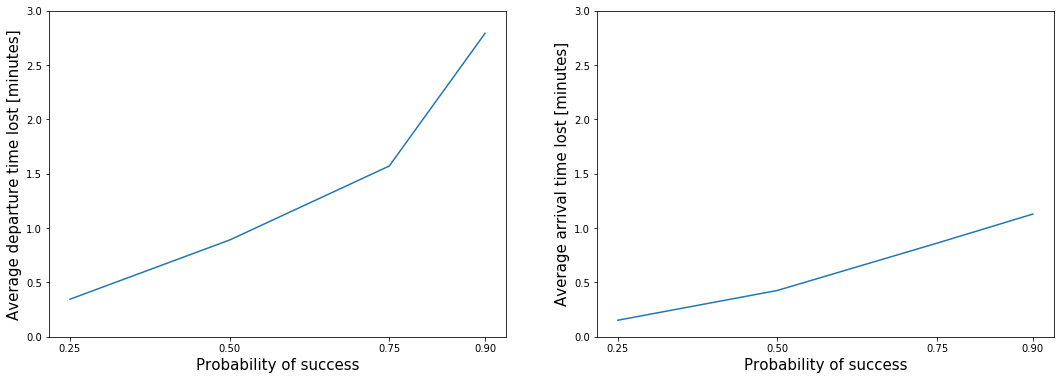

In [139]:
plot_validation_time_loss(min_prob_successes, departure_time_loss, arrival_time_loss)

#### Results

In this test we compute the average departure / arrival time lost compared to the fastest possible schedule over 500 random queries. The average departure time lost is computed over the queries which specify an arrival time and the average arrival time lost is computed over the queries which specify a departure time.

We can see that, as expected, we lose more time when we ask for a higher minimum probability of success. But on average the time lost is not very significant (less than 3 minutes).

In [67]:
min_prob_successes = [0.25, 0.50, 0.75, 0.90]

nb_validation_queries = 50

print('Generating  dep  low  prob  queries  ', end=' ')
dep_validation_queries = get_random_query_low_prob_batch(batchsize=nb_validation_queries, threshold=0.80, 
                                                         random_week=True, mode='departure')
print(' done')
print('Generating  arr  low  prob  queries  ', end=' ')
arr_validation_queries = get_random_query_low_prob_batch(batchsize=nb_validation_queries, threshold=0.80, 
                                                         random_week=True, mode='arrival')
print(' done')

departure_time_loss_low_prob = []
arrival_time_loss_low_prob = []

for min_prob_success in min_prob_successes:
    print('Avg dep time lost with min prob {:.2f} '.format(min_prob_success), end=' ')
    avg_deptime_lost = benchmark_average_time_loss(arr_validation_queries, mode='arrival', min_prob_success=min_prob_success)
    print(' done', ' {:.2f}'.format(avg_deptime_lost))
    
    departure_time_loss_low_prob.append(avg_deptime_lost)
    
for min_prob_success in min_prob_successes:
    print('Avg arr time lost with min prob {:.2f} '.format(min_prob_success), end=' ')
    avg_arrtime_lost = benchmark_average_time_loss(dep_validation_queries, mode='departure', min_prob_success=min_prob_success)
    print(' done', ' {:.2f}'.format(avg_arrtime_lost))
    
    arrival_time_loss_low_prob.append(avg_arrtime_lost)

Generating  dep  low  prob  queries   ################################################## done
Generating  arr  low  prob  queries   ################################################## done
Avg dep time lost with min prob 0.25  ################################################## done  2.72
Avg dep time lost with min prob 0.50  ################################################## done  5.46
Avg dep time lost with min prob 0.75  ################################################## done  8.98
Avg dep time lost with min prob 0.90  ################################################## done  10.42
Avg arr time lost with min prob 0.25  ################################################## done  0.30
Avg arr time lost with min prob 0.50  ################################################## done  1.26
Avg arr time lost with min prob 0.75  ################################################## done  4.82
Avg arr time lost with min prob 0.90  ################################################## done  6.18


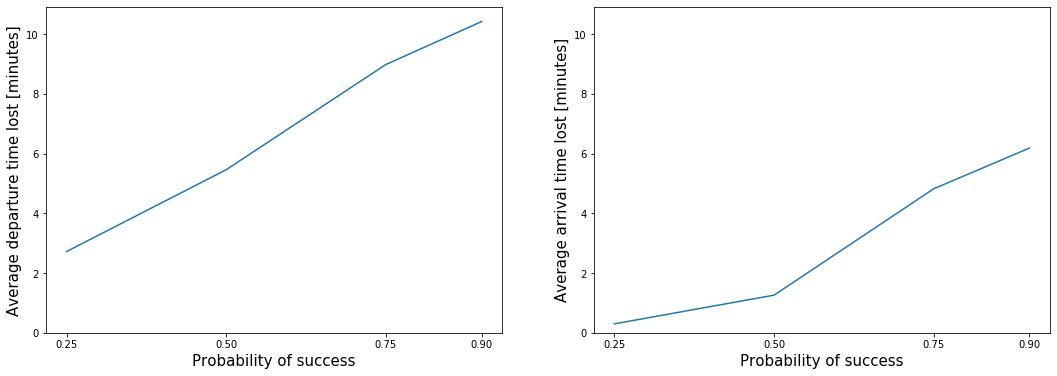

In [68]:
plot_validation_time_loss(min_prob_successes, departure_time_loss_low_prob, arrival_time_loss_low_prob)

#### Results

We repeat the previous test for queries for which the fastest possible schedule has a probability of success lower than 80%. We use 50 queries where we specify the departure time and 50 where we specify the arrival time.

As expected we're going to lose more time on such queries, so there's a real compromise between time and risk.

### Execution time benchmark

In [16]:
print('Computing average exec times ', end=' ')
bins, values = benchmark_average_exec_time()
print(' done')

Computing average exec times  ################################################## done


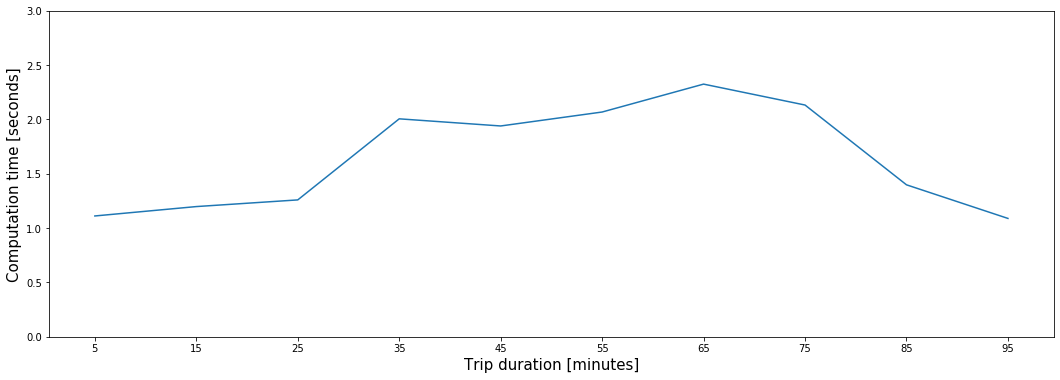

In [140]:
plt.figure(figsize=(18,6))
plt.xlabel('Trip duration [minutes]', fontsize=15)
plt.ylabel('Computation time [seconds]', fontsize=15)
plt.plot(bins, values)
plt.xticks(ticks=[x for x in range(bins[0], bins[-1] + 10, 10)]);
plt.ylim(bottom=0, top=3);

#### Results

In this test we use 1000 randomly generated queries to find the average time required to compute the schedule depending on the returned duration for the trip. We group the results in intervals of 10 minutes and plot the average value for that group in the middle of the interval, i.e., the value plotted at 5 minutes on the x axis is the average computation time for trips whose duration is between 0 and 9 minutes.

We can see that the computation time is very reasonable, with the highest average time at less than 2.5 seconds for trips that take between 60 and 69 minutes.